<a href="https://colab.research.google.com/github/AleidaliMac/Academic_projects/blob/main/LSTM_4Music_QuarantineHub_Talk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conexión a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Referencias


* https://colah.github.io/posts/2015-08-Understanding-LSTMs/

* https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

* https://www.youtube.com/watch?v=rdkIOM78ZPk&t=110s

* https://www.youtube.com/watch?v=aircAruvnKk&t=207s



# Librerías

In [ ]:
import keras
import numpy as np
import pandas as pd
from keras import layers 
from keras.layers import Dense, BatchNormalization,Embedding
from keras.models import Sequential
import tensorflow as tf #para early stopping   
import random
import sys    
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
!pip install music21

In [ ]:
import pickle
import numpy
import os
import music21
from music21 import converter, instrument, note, chord, stream
from IPython.display import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint

In [ ]:
import music21
from music21 import converter, instrument, note, chord, stream

In [ ]:
my_note = music21.note.Note("C")
my_note.duration.quarterLength = 2
print(my_note.fullName)
print(my_note)
# my_note.show('musicxml.xml')

C Half Note
<music21.note.Note C>


In [ ]:
my_note.show('midi')

  # Lectura MIDI files

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Bases_CD/')

#SONGS:
# song='MIDI_songs/HighwayToHell.mid'
# song='MIDI_songs/BackToBlack.mid'
song='MIDI_songs/original_metheny.mid'
# song='classic_piano_corpus/classic_piano_corpus/midi_train/midi_train/bach_846.mid'
#Partitura
midi=converter.parse(song)
midi.show('text')


{0.0} <music21.stream.Part 0x7f277a80ba58>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.tempo.MetronomeMark Quarter=112.0>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.stream.Voice 0x7f277a2f22e8>
        {0.0} <music21.note.Rest rest>
        {4.0} <music21.chord.Chord C4 A3 E4 G3 F2>
        {5.75} <music21.chord.Chord E4 C4 A3 G3 F2>
        {6.5} <music21.chord.Chord F3 B-3 A3 D4>
        {8.0} <music21.chord.Chord D2 C4 E3 F3 A3>
        {10.5} <music21.chord.Chord B-2 F4 C4 D4 A4>
        {11.0} <music21.chord.Chord B-3 E-3 F4 D4 G3>
        {12.5} <music21.chord.Chord C4 E4 A3 F3 D2>
        {13.75} <music21.chord.Chord F3 A3 E4 C4 D2>
        {14.5} <music21.chord.Chord B-3 F4 D4 A3>
        {20.0} <music21.chord.Chord C4 A3 E4 G3 F2>
        {21.75} <music21.chord.Chord E4 C4 A3 G3 F2>
        {22.5} <music21.chord.Chord F3 B-3 A3 D4>
        {24.0} <music21.chord.Chord D2 C4 E3 F3 A3>
        {26.5} <mu

##Instrumentos en la partitura

In [ ]:
midi_parts = instrument.partitionByInstrument(midi)
for element in midi_parts.parts:
    print(element)

<music21.stream.Part Piano>
<music21.stream.Part Acoustic Bass>
<music21.stream.Part Electric Guitar>
<music21.stream.Part Trumpet>
<music21.stream.Part Horn>


##Elementos del i-ésimo instrumento, en este caso el primero

In [ ]:
for i in midi_parts.parts[0].recurse():
  print(i)

Se han truncado las últimas 5000 líneas del flujo de salida.
<music21.chord.Chord B-2 F4 C4 D4 A4>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.chord.Chord B-3 E-3 F4 D4 G3>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.chord.Chord C4 E4 A3 F3 D2>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.chord.Chord F3 A3 E4 C4 D2>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.note.Note G#>
<music21.note.Rest rest>
<music21.chord.Chord

## Extrayendo intrumentos, Notas, acordes , duraciones y silencios

In [ ]:
# file ='MIDI_songs/HighwayToHell.mid'
file='MIDI_songs/original_metheny.mid'
midi = converter.parse(file)  
parts = instrument.partitionByInstrument(midi) 
notes_for_instruments = []
instruments=[]
for i in range(len(parts.parts)): 
    notes_to_parse = parts.parts[i].recurse()
    instr = parts.parts[i].getInstrument()
    instruments.append(instr.instrumentName)
    notes, quarters = [],[] 
    for element in notes_to_parse:   
        if isinstance(element, note.Note):  
        # if element is a note, extract pitch   
            # print(element)
            # print(str(element.offset))
            notes.append(str(element.pitch))
        elif(isinstance(element, chord.Chord)): 
            # print(element)
            # print(str(element.offset))
            # print(element.normalOrder) 
            # if element is a chord, append the normal form of the   
            # chord (a list of integers) to the list of notes.   
            notes.append('.'.join(str(n) for n in element.normalOrder))  
        elif isinstance(element, note.Rest):
            notes.append('Rest')

    notes_for_instruments.append(notes)

In [ ]:
notes_for_instruments

[['Rest',
  'Rest',
  'Rest',
  'Rest',
  'Rest',
  '4.5.7.9.0',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '4.5.7.9.0',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '9.10.2.5',
  'C3',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '9.0.2.4.5',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '9.10.0.2.5',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '2.3.5.7.10',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '9.0.2.4.5',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '9.0.2.4.5',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  'G#2',
  'Rest',
  '9.10.2.5',

##Orden normal de un acorde

In [ ]:
#El orden normal es la forma más comprimida de escribir una colección determinada de notas
acorde1=chord.Chord(['B-3','E3','F4','D4','G3'])
acorde1.normalOrder

[2, 4, 5, 7, 10]

# *1. Función para obtener las notas (realiza todo lo anterior)*

In [ ]:
def get_notes():
    """ Obtiene las notas y acordes de los archivos midi que se encuentran en el directorio /midi_songs """
    notes = []

    for file in os.scandir(midi_songs):
        midi = converter.parse(file.path)

        print("Analizando %s" % file.name)

        notes_to_parse = None

        # en esta parte, se extraen todas las notas del archivo midi
        # como 'midi' es un objeto Score (que a su vez hereda de un Stream),
        # pueden accederse a todas las partes de la partitura (Score)
        
        # se consideran los casos en que el archivo midi tenga partes que correspondan a diferentes instrumentos
        # (solo se usa el primero, aunque puedan haber mas de 1), o que tenga solo las notas
        midi_parts = instrument.partitionByInstrument(midi)
        if midi_parts: 
            notes_to_parse = midi_parts.parts[0].recurse() #Solo se utiliza la info del primer instrumento o parte de la partitura
        else: # notas en estructura flat
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    # guarda las notas. Este paso es muy importante, ya que se usaran en la fase de test,
    # es decir, cuando se generan notas a partir del modelo entrenado
    with open('/content/drive/My Drive/Bases_CD/classic_piano_corpus/classic_piano_corpus/data_mid/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [ ]:
midi_songs='MIDI_songs' #indico el nombre de la carpeta donde se encuentran todas las canciones que conformarán mi corpus
notas=get_notes() # aplico la función 

Analizando HighwayToHell.mid
Analizando BackToBlack.mid
Analizando original_metheny.mid


In [ ]:
np.asarray(notas[:100])

array(['F#2', 'F#2', 'F#2', 'F#2', 'F#2', '2.4.9', '2.4.9', '2.6.9',
       '2.6.9', '2.7', '2.6.9', '2.6.9', '2.7', '2.6.9', '2.6.9', '2.7',
       '2.6.9', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '8.11',
       '4.8', '8.11', '2.6.9', '2.6.9', '4.8', '2.7', '8.11', '4.8',
       '8.11', '2.6.9', '2.6.9', '4.8', '2.7', '8.11', '2.6.9', '2.6.9',
       '4.8', '2.7', '8.11', '2.6.9', '4.8', '9.1.4', '8.11', '9.1.4',
       '8.11', '4.8', '8.11', '9.1.4', '9.1.4', '4.8', '9.1.4', '8.11',
       '8.11', 'F#4', '4.8', 'A4', '8.11', 'C5', '2.6.9', 'C#5', '2.6.9',
       '4.8', '2.7', '8.11', '8.11', '4.8', 'A4', '8.11', 'A4', '2.6.9',
       '2.6.9', '4.8', '2.7', '8.11', '8.11', '2.6.9', '2.6.9', '4.8',
       'F#4', '2.7', 'A4', '8.11', 'A4', '2.6.9', 'F#4', '4.8', 'A4',
       '9.1.4', '8.11', 'F#4', '9.1.4', '8.11', 'C5', 'A4', '4.8', 'G4',
       'A4'], dtype='<U5')

#Creando DIccionario

In [ ]:
pitchnames = sorted(set(item for item in notas))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
note_to_int
n_vocab = len(set(notas))
n_vocab

164

Mapeo a espacio numérico

In [ ]:
test_num=np.asarray([note_to_int[char] for char in notas])[:100]
test_num

array([147, 147, 147, 147, 147,  34,  34,  40,  40,  41,  40,  40,  41,
        40,  40,  41,  40, 105, 105, 105, 105, 105,  97,  62,  97,  40,
        40,  62,  41,  97,  62,  97,  40,  40,  62,  41,  97,  40,  40,
        62,  41,  97,  40,  62, 105,  97, 105,  97,  62,  97, 105, 105,
        62, 105,  97,  97, 149,  62, 114,  97, 131,  40, 127,  40,  62,
        41,  97,  97,  62, 114,  97, 114,  40,  40,  62,  41,  97,  97,
        40,  40,  62, 149,  41, 114,  97, 114,  40, 149,  62, 114, 105,
        97, 149, 105,  97, 131, 114,  62, 163, 114])

Re-escalando valores

In [ ]:
n_vocab = len(set(notas))
test_std = test_num / float(n_vocab)
test_std

array([0.89634146, 0.89634146, 0.89634146, 0.89634146, 0.89634146,
       0.20731707, 0.20731707, 0.24390244, 0.24390244, 0.25      ,
       0.24390244, 0.24390244, 0.25      , 0.24390244, 0.24390244,
       0.25      , 0.24390244, 0.6402439 , 0.6402439 , 0.6402439 ,
       0.6402439 , 0.6402439 , 0.59146341, 0.37804878, 0.59146341,
       0.24390244, 0.24390244, 0.37804878, 0.25      , 0.59146341,
       0.37804878, 0.59146341, 0.24390244, 0.24390244, 0.37804878,
       0.25      , 0.59146341, 0.24390244, 0.24390244, 0.37804878,
       0.25      , 0.59146341, 0.24390244, 0.37804878, 0.6402439 ,
       0.59146341, 0.6402439 , 0.59146341, 0.37804878, 0.59146341,
       0.6402439 , 0.6402439 , 0.37804878, 0.6402439 , 0.59146341,
       0.59146341, 0.90853659, 0.37804878, 0.69512195, 0.59146341,
       0.79878049, 0.24390244, 0.77439024, 0.24390244, 0.37804878,
       0.25      , 0.59146341, 0.59146341, 0.37804878, 0.69512195,
       0.59146341, 0.69512195, 0.24390244, 0.24390244, 0.37804

In [ ]:
len(notas) - sequence_length

4711

In [ ]:
network_input = []
network_output = []
sequence_length=10
for i in range(0, len(notas) - sequence_length, 1):
  sequence_in = notas[i:i + sequence_length] # el ultimo elemento no lo considera
  sequence_out = notas[i + sequence_length] #guarda la siguiente nota despues de la secuencia , son las y's
  network_input.append([note_to_int[char] for char in sequence_in])
  network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input) #numero de secuencias 
#convierte de lista a arreglo 
# redimensiona las secuencias de entrada para la RNN a usar
network_input = numpy.reshape(network_input, (n_patterns, sequence_length))

n_vocab = len(set(notas))
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)
for i in range(6):
  print(np.round(network_input[i],3),"\n",network_output[i])

[0.896 0.896 0.896 0.896 0.896 0.207 0.207 0.244 0.244 0.25 ] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.896 0.896 0.896 0.896 0.207 0.207 0.244 0.244 0.25  0.244] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

# *2. Función que prepara las secuencias para el entrenamiento (hace todo lo anterior)* 

In [ ]:
def prepare_sequences(notes, n_vocab, sequence_length):
    """ Prepara las secuencias a usar en el modelo """

    # nuestro 'vocabulario' consiste en todas las notas unicas de los archivos midi
    pitchnames = sorted(set(item for item in notes))

     # se crea un diccionario para mapear notas a enteros
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # crea las secuencias de entrada y las salidas
    # podria usarse para una arquitectura 'many to one', pero también puedes
    # hacer un stack de RNNs (many to many)
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length] # el ultimo elemento no lo considera
        sequence_out = notes[i + sequence_length] #guarda la siguiente nota despues de la secuencia , son las y's
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input) #numero de secuencias 
    #convierte de lista a arreglo 
    # redimensiona las secuencias de entrada para la RNN a usar
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normaliza
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)


# *3.Funciones que realizan la predicción y la convierten a formato midi*

In [ ]:
def prepare_sequences_test(notes, pitchnames, n_vocab,sequence):
    """ Prepara las secuencias para usar en el modelo entrenado """
    #pitchnames es el vocabulario ordenado
    # aqui, se realiza un mapeo (con diccionario) entre las notas y valores enteros y al reves
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = sequence
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # como antes, redimensionamos las entradas para poder usarse con LSTM
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalizamos la entrada
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

def generate_notes_test(model, network_input, pitchnames, n_vocab):
    """ Genera notas musicales a partir de una red neuronal basado en una secuencia inicial de notas """
    
    # selecciona una secuencia aleatoria del input a partir de la cual se realizaran predicciones
    start = numpy.random.randint(0, len(network_input)-1)
    #diccionario
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # genera 500 notas (puedes cambiarlo)
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output, midfile):
    """ genera un archivo MIDI a partir de las notas generadas (o predichas) """
    offset = 0
    output_notes = []

    # crea los objetos fundamentales Note y Chrod basado en los valores generados por el modelo entrenado
    for pattern in prediction_output:
        # si las notas forman un acorde...
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # si son notas...
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # incremental el offset en cada iteracion. El offset es la posicion dentro del stream de musica
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp = midfile)


# *4. (Compilación de funciones)*

In [ ]:
""" Genera las notas y el archivo MIDI (piano) """

# carga las notas usadas cuando se entreno el modelo
with open('/content/drive/My Drive/Bases_CD/classic_piano_corpus/classic_piano_corpus/data_mid/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Obtiene el nombre de todas las notas (pitches)
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

""" Obtiene las secuencias Genera las notas y el archivo MIDI (piano) """
network_input, normalized_input = prepare_sequences_test(notes, pitchnames, n_vocab)

# carga el modelo entrenado
from keras.models import load_model
model = load_model('/content/drive/My Drive/Bases_CD/classic_piano_corpus/Mi_modelo.hdf5')
# genera las notas
prediction_output = generate_notes_test(model, network_input, pitchnames, n_vocab)
# crea el MIDI
create_midi(prediction_output, '/content/drive/My Drive/Bases_CD/classic_piano_corpus/test_output.mid')

#Ejemplo 1: Usando corpus - Bach & Tchaicovsky

Se prueba eligiendo sólo las melodías de Bach & Tchaicovsky. http://www.piano-midi.de/midicoll.htm

Con este modelo se logró obtener un nivel de loss bajo y con este se produjeron las melodías más armoniosas.



In [ ]:
#Para subir archivos a drive
# from google.colab import files
# files.upload()

In [ ]:
#Descomprime archivos 
# !unzip bach.zip;
!unzip tschai.zip;

Archive:  tschai.zip
  inflating: ty_januar.mid           
  inflating: ty_februar.mid          
  inflating: ty_april.mid            
  inflating: ty_maerz.mid            
  inflating: ty_mai.mid              
  inflating: ty_juni.mid             
  inflating: ty_juli.mid             
  inflating: ty_august.mid           
  inflating: ty_september.mid        
  inflating: ty_oktober.mid          
  inflating: ty_dezember.mid         
  inflating: ty_november.mid         


In [ ]:
os.chdir('/content/drive/My Drive/Bases_CD/classic_piano_corpus/classic_piano_corpus/')#raiz
# el directorio con el corpus de entrenamiento
midi_songs = 'bach&tchai_train'
#LONGITUD DE SECUENCIA
sequence = 50

In [ ]:
#Función que obtiene las notas
notes = get_notes()
# cantidad de notas únicas
n_vocab = len(set(notes))
print('vocabulario:', n_vocab)

Analizando bach_846.mid
Analizando bach_847.mid
Analizando bach_850.mid
Analizando ty_januar.mid
Analizando ty_februar.mid
Analizando ty_maerz.mid
Analizando ty_april.mid
Analizando ty_mai.mid
Analizando ty_juni.mid
Analizando ty_juli.mid
Analizando ty_august.mid
Analizando ty_september.mid
Analizando ty_oktober.mid
Analizando ty_november.mid
Analizando ty_dezember.mid
vocabulario: 229


In [ ]:
#Función que crea las secuencias
network_input, network_output = prepare_sequences(notes, n_vocab, sequence)
print(network_input.shape)
print(network_output.shape)

(17057, 50, 1)
(17057, 229)


In [ ]:
del model

In [ ]:
model = Sequential()
model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 50, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 512)           2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [ ]:
filepath = "/content/drive/My Drive/Bases_CD/TEST/{epoch:02d}-{loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=0,
                             save_best_only=True,mode='min')

early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True)
callbacks_list = [early]
# callbacks_list = [checkpoint,early]

hist=model.fit(network_input, network_output, epochs=50, batch_size=64, 
          callbacks=callbacks_list)

Epoch 1/50
267/267 [==============================] - 21s 40ms/step - loss: 4.6751 - acc: 0.0333
Epoch 2/50
267/267 [==============================] - 11s 40ms/step - loss: 4.3735 - acc: 0.0389
Epoch 3/50
267/267 [==============================] - 11s 41ms/step - loss: 4.3417 - acc: 0.0380
Epoch 4/50
267/267 [==============================] - 11s 41ms/step - loss: 4.3122 - acc: 0.0390
Epoch 5/50
267/267 [==============================] - 11s 41ms/step - loss: 4.2621 - acc: 0.0458
Epoch 6/50
267/267 [==============================] - 11s 42ms/step - loss: 4.2043 - acc: 0.0484
Epoch 7/50
267/267 [==============================] - 11s 42ms/step - loss: 4.1019 - acc: 0.0626
Epoch 8/50
267/267 [==============================] - 11s 42ms/step - loss: 3.9665 - acc: 0.0768
Epoch 9/50
267/267 [==============================] - 11s 42ms/step - loss: 3.7906 - acc: 0.1083
Epoch 10/50
267/267 [==============================] - 11s 41ms/step - loss: 3.6033 - acc: 0.1390
Epoch 11/50
267/267 [========

In [ ]:
model.save('/content/drive/My Drive/Bases_CD/TEST/Mi_modelo_3.h5')

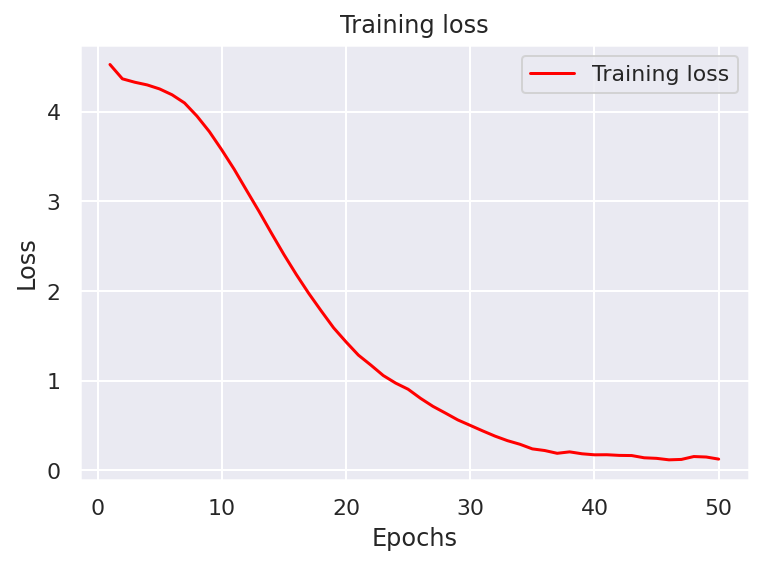

In [ ]:
# MODELO 3 
# Usando nuevo corpus, uso Adam y 15 épocas, lo guardé en Mi_modelo_Nuevo_Corpus.h5
# La longitud de secuencia = 50
loss=hist.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color="red", label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Se continuó entrenando el modelo, se recuperan los pesos hasta donde se había entrenado y se agregan 30 épocas mas.

In [ ]:
from tensorflow.keras.models import load_model
#El modelo se guardó en 
new_model=load_model('/content/drive/My Drive/Bases_CD/TEST/Mi_modelo_3.h5')

In [ ]:
filepath = "/content/drive/My Drive/Bases_CD/TEST/{epoch:02d}-{loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=0,
                             save_best_only=True,mode='min')

early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True)
callbacks_list = [early]
# callbacks_list = [checkpoint,early]

hist=new_model.fit(network_input, network_output, epochs=50, batch_size=64, 
          callbacks=callbacks_list)

Epoch 1/50
267/267 [==============================] - 12s 39ms/step - loss: 0.1047 - acc: 0.9714
Epoch 2/50
267/267 [==============================] - 11s 40ms/step - loss: 0.1135 - acc: 0.9712
Epoch 3/50
267/267 [==============================] - 11s 40ms/step - loss: 0.1321 - acc: 0.9667
Epoch 4/50
267/267 [==============================] - 11s 40ms/step - loss: 0.1332 - acc: 0.9668
Epoch 5/50
267/267 [==============================] - 11s 41ms/step - loss: 0.1348 - acc: 0.9647
Epoch 6/50
267/267 [==============================] - 11s 41ms/step - loss: 0.1090 - acc: 0.9714


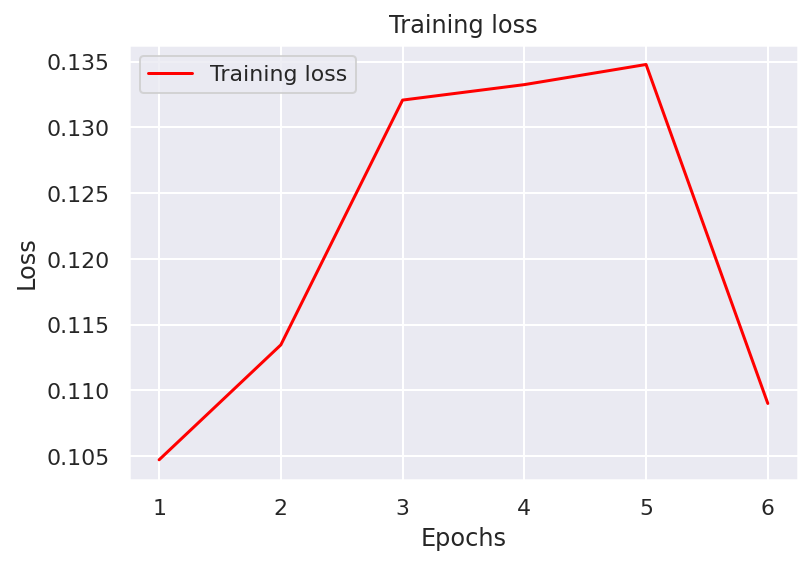

In [ ]:
loss=hist.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color="red", label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

El early stopping se activó en la época 6, lo que significa que la función loss ya no estaba descendiendo, hasta este punto se logró un loss de 0.10.

In [ ]:
#Guardamos de nuevo el modelo 3 versión 3.1
new_model.save('/content/drive/My Drive/Bases_CD/TEST/Mi_modelo_3.1.h5')

In [ ]:
""" Genera las notas y el archivo MIDI (piano) """
#tamaño de secuencia
lenseq=50
# carga las notas usadas cuando se entreno el modelo
with open('/content/drive/My Drive/Bases_CD/classic_piano_corpus/classic_piano_corpus/data_mid/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Obtiene el nombre de todas las notas (pitches)
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

""" Obtiene las secuencias Genera las notas y el archivo MIDI (piano) """
network_input, normalized_input = prepare_sequences_test(notes, pitchnames, n_vocab,sequence=lenseq)
print(len(network_input))

# carga el modelo entrenado
from keras.models import load_model
model = load_model('/content/drive/My Drive/Bases_CD/TEST/Mi_modelo_3.1.h5')
# genera las notas
prediction_output = generate_notes_test(model, network_input, pitchnames, n_vocab)
print(len(prediction_output))
# crea el MIDI
create_midi(prediction_output, '/content/drive/My Drive/Bases_CD/TEST/Modelo3.1_Output1.mid')

17057
500


In [ ]:
base_midi = converter.parse('/content/drive/My Drive/Bases_CD/TEST/Modelo3.1_Output1.mid')
print(base_midi)
base_midi.show('text')


<music21.stream.Score 0x7f9abc737d68>
{0.0} <music21.stream.Part 0x7f9b272f5080>
    {0.0} <music21.stream.Voice 0x7f9b272f50f0>
        {0.0} <music21.note.Note D>
        {1.0} <music21.chord.Chord G4 B4>
        {2.0} <music21.note.Note E->
        {3.0} <music21.note.Note G>
        {4.0} <music21.note.Note C>
        {5.0} <music21.note.Note F>
        {6.0} <music21.chord.Chord F4 G4>
        {7.0} <music21.note.Note C>
        {8.0} <music21.note.Note C>
        {9.0} <music21.note.Note G>
        {10.0} <music21.chord.Chord G4 A4>
        {11.0} <music21.note.Note D>
        {12.0} <music21.note.Note D>
        {13.0} <music21.note.Note C#>
        {14.0} <music21.chord.Chord E4 G4 A4>
        {15.0} <music21.note.Note F>
        {16.0} <music21.note.Note A>
        {17.0} <music21.note.Note D>
        {18.0} <music21.note.Note E>
        {19.0} <music21.chord.Chord A4 C#4>
        {20.0} <music21.note.Note F>
        {21.0} <music21.note.Note A>
        {22.0} <music21.note.No

#Ejemplo 2: Final Fantasy songs

In [ ]:
os.chdir('/content/drive/My Drive/Bases_CD/')#raiz
# el directorio con el corpus de entrenamiento
midi_songs = 'midi_songs_FF'
#LONGITUD DE SECUENCIA
sequence = 80

In [ ]:
#Función que obtiene las notas
notes = get_notes()
# cantidad de notas únicas
n_vocab = len(set(notes))
print('vocabulario:', n_vocab)

Analizando FF3_Third_Phase_Final_(Piano).mid
Analizando Finalfantasy5gilgameshp.mid
Analizando In_Zanarkand.mid
Analizando thoughts.mid
Analizando JENOVA.mid
Analizando Suteki_Da_Ne_(Piano_Version).mid
Analizando ff4_piano_collections-main_theme.mid
Analizando ff4-fight1.mid
Analizando Still_Alive-1.mid
Analizando Finalfantasy6fanfarecomplete.mid
Analizando Ff7-One_Winged.mid
Analizando Eternal_Harvest.mid
Analizando bcm.mid
Analizando pkelite4.mid
Analizando z_aeristhemepiano.mid
Analizando FF4.mid
Analizando Kingdom_Hearts_Traverse_Town.mid
Analizando Oppressed.mid
Analizando Kingdom_Hearts_Dearly_Beloved.mid
Analizando fortresscondor.mid
Analizando FFIXQuMarshP.mid
Analizando Fiend_Battle_(Piano).mid
Analizando 8.mid
Analizando sandy.mid
Analizando balamb.mid
Analizando Final_Fantasy_7_-_Judgement_Day_Piano.mid
Analizando Rachel_Piano_tempofix.mid
Analizando VincentPiano.mid
Analizando ff4pclov.mid
Analizando ff7-mainmidi.mid
Analizando EyesOnMePiano.mid
Analizando Ff7-Jenova_Absolu

In [ ]:
#Función que crea las secuencias
network_input, network_output = prepare_sequences(notes, n_vocab, sequence)
print(network_input.shape)
print(network_output.shape)

(57097, 80, 1)
(57097, 358)


In [ ]:
del model

In [ ]:
model = Sequential()
model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 80, 512)           1052672   
_________________________________________________________________
dropout_6 (Dropout)          (None, 80, 512)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 80, 512)           2099200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [ ]:
filepath = "/content/drive/My Drive/Bases_CD/TEST/{epoch:02d}-{loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=0,
                             save_best_only=True,mode='min')

early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20,restore_best_weights=True)
callbacks_list = [early]
# callbacks_list = [checkpoint,early]

hist=model.fit(network_input, network_output, epochs=200, batch_size=64, 
          callbacks=callbacks_list)

Epoch 1/200
893/893 [==============================] - 63s 67ms/step - loss: 4.8255 - acc: 0.0233
Epoch 2/200
893/893 [==============================] - 59s 66ms/step - loss: 4.7095 - acc: 0.0239
Epoch 3/200
893/893 [==============================] - 59s 66ms/step - loss: 4.7088 - acc: 0.0235
Epoch 4/200
893/893 [==============================] - 60s 67ms/step - loss: 4.7119 - acc: 0.0252
Epoch 5/200
893/893 [==============================] - 59s 67ms/step - loss: 4.7090 - acc: 0.0253
Epoch 6/200
893/893 [==============================] - 59s 67ms/step - loss: 4.7054 - acc: 0.0265
Epoch 7/200
893/893 [==============================] - 59s 66ms/step - loss: 4.7074 - acc: 0.0248
Epoch 8/200
893/893 [==============================] - 59s 66ms/step - loss: 4.7040 - acc: 0.0255
Epoch 9/200
893/893 [==============================] - 59s 67ms/step - loss: 4.7066 - acc: 0.0241
Epoch 10/200
893/893 [==============================] - 59s 67ms/step - loss: 4.7054 - acc: 0.0239
Epoch 11/200
893/89

In [ ]:
model.save('/content/drive/My Drive/Bases_CD/TEST/Mi_modelo_4.h5')

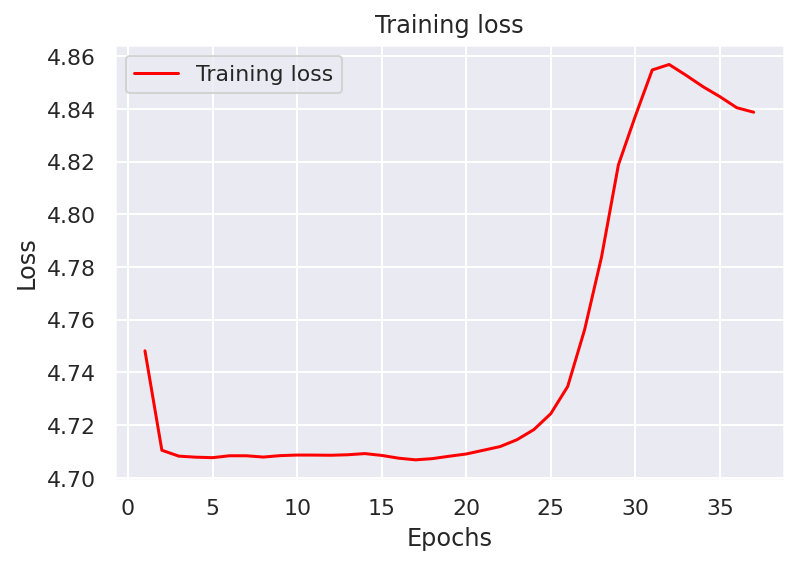

In [ ]:
# MODELO 4
# La longitud de secuencia = 50
loss=hist.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color="red", label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Ejemplo 3: Final Fantasy & Zelda

http://www.zeldacentral.com/midi.shtml

In [ ]:
os.chdir('/content/drive/My Drive/Bases_CD/')#raiz
# el directorio con el corpus de entrenamiento
midi_songs = 'FF_Zelda'
#LONGITUD DE SECUENCIA
sequence = 50

In [ ]:
#Función que obtiene las notas
notes = get_notes()
# cantidad de notas únicas
n_vocab = len(set(notes))
print('vocabulario:', n_vocab)

Analizando balamb.mid
Analizando thenightmarebegins.mid
Analizando tifap.mid
Analizando gerudo.mid
Analizando figaro.mid
Analizando relmstheme-piano.mid
Analizando waltz_de_choco.mid
Analizando Eternal_Harvest.mid
Analizando traitor.mid
Analizando Rachel_Piano_tempofix.mid
Analizando EyesOnMePiano.mid
Analizando thoughts.mid
Analizando ultros.mid
Analizando Still_Alive-1.mid
Analizando JENOVA.mid
Analizando tpirtsd-piano.mid
Analizando Zelda_Overworld.mid
Analizando electric_de_chocobo.mid
Analizando bolero-of-fire.mid
Analizando Dungeon 1.mid
vocabulario: 201


In [ ]:
#Función que crea las secuencias
network_input, network_output = prepare_sequences(notes, n_vocab, sequence)
print(network_input.shape)
print(network_output.shape)

(11332, 50, 1)
(11332, 201)


In [ ]:
del model

In [ ]:
model = Sequential()
model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 512)           1052672   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 512)           2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [ ]:
filepath = "/content/drive/My Drive/Bases_CD/TEST/{epoch:02d}-{loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=0,
                             save_best_only=True,mode='min')

early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)
callbacks_list = [early]
# callbacks_list = [checkpoint,early]

hist=model.fit(network_input, network_output, epochs=100, batch_size=64, 
          callbacks=callbacks_list)

Epoch 1/100
178/178 [==============================] - 7s 38ms/step - loss: 4.4863 - acc: 0.0325
Epoch 2/100
178/178 [==============================] - 7s 38ms/step - loss: 4.2718 - acc: 0.0488
Epoch 3/100
178/178 [==============================] - 7s 39ms/step - loss: 4.1128 - acc: 0.0633
Epoch 4/100
178/178 [==============================] - 7s 39ms/step - loss: 4.0140 - acc: 0.0752
Epoch 5/100
178/178 [==============================] - 7s 39ms/step - loss: 3.8710 - acc: 0.1035
Epoch 6/100
178/178 [==============================] - 7s 40ms/step - loss: 3.6989 - acc: 0.1310
Epoch 7/100
178/178 [==============================] - 7s 40ms/step - loss: 3.5367 - acc: 0.1617
Epoch 8/100
178/178 [==============================] - 7s 40ms/step - loss: 3.3386 - acc: 0.2017
Epoch 9/100
178/178 [==============================] - 7s 40ms/step - loss: 3.0892 - acc: 0.2510
Epoch 10/100
178/178 [==============================] - 7s 40ms/step - loss: 2.8221 - acc: 0.2979
Epoch 11/100
178/178 [=======

In [ ]:
model.save('/content/drive/My Drive/Bases_CD/TEST/Mi_modelo_FF_Zelda.h5')

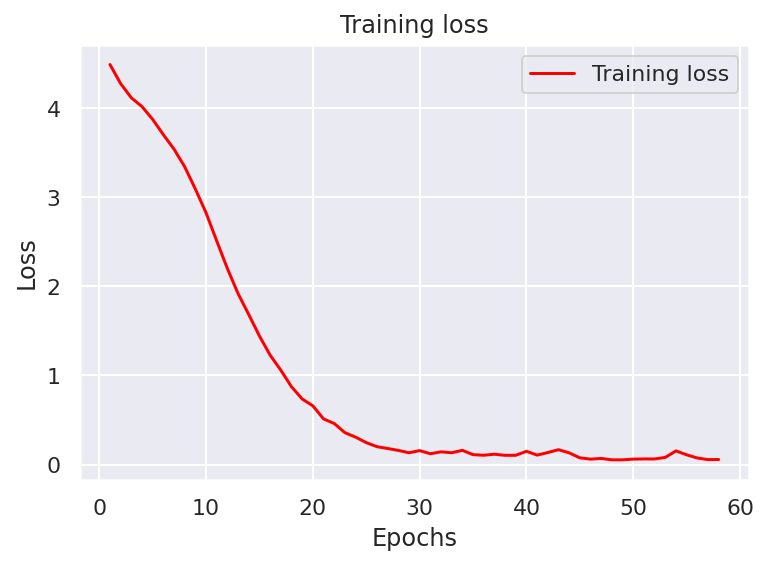

In [ ]:
# MODELO 3
# La longitud de secuencia = 50
loss=hist.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color="red", label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
""" Genera las notas y el archivo MIDI (piano) """
#tamaño de secuencia
lenseq=50
# carga las notas usadas cuando se entreno el modelo
with open('/content/drive/My Drive/Bases_CD/classic_piano_corpus/classic_piano_corpus/data_mid/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Obtiene el nombre de todas las notas (pitches)
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

""" Obtiene las secuencias Genera las notas y el archivo MIDI (piano) """
network_input, normalized_input = prepare_sequences_test(notes, pitchnames, n_vocab,sequence=lenseq)
print(len(network_input))

# carga el modelo entrenado
from keras.models import load_model
model = load_model('/content/drive/My Drive/Bases_CD/TEST/Mi_modelo_FF_Zelda.h5')
# genera las notas
prediction_output = generate_notes_test(model, network_input, pitchnames, n_vocab)
print(len(prediction_output))
# crea el MIDI
create_midi(prediction_output, '/content/drive/My Drive/Bases_CD/TEST/Output_FF_Z_2.mid')

11332
500


In [ ]:
base_midi = converter.parse('/content/drive/My Drive/Bases_CD/TEST/Output_FF_Z.mid')
print(base_midi)
base_midi.show('text')

<music21.stream.Score 0x7fdce6171d30>
{0.0} <music21.stream.Part 0x7fdce6f9a080>
    {0.0} <music21.stream.Voice 0x7fdce6f9a0f0>
        {0.0} <music21.note.Note D>
        {1.0} <music21.note.Note B>
        {2.0} <music21.note.Note A>
        {3.0} <music21.note.Note D>
        {4.0} <music21.note.Note C>
        {5.0} <music21.note.Note G>
        {6.0} <music21.note.Note A>
        {6.5} <music21.note.Note G>
        {7.5} <music21.note.Note A>
        {8.0} <music21.note.Note F>
        {9.5} <music21.note.Note A>
        {10.5} <music21.chord.Chord F4 A4>
        {11.5} <music21.chord.Chord B-4 C#4>
        {12.5} <music21.note.Note F>
        {13.5} <music21.note.Note B->
        {14.5} <music21.note.Note C>
        {15.0} <music21.note.Note E->
        {16.0} <music21.note.Note F>
        {17.0} <music21.note.Note C>
        {18.0} <music21.note.Note C>
        {19.0} <music21.chord.Chord G4 A4 C4>
        {20.0} <music21.note.Note E>
        {21.0} <music21.note.Note A>
      